In [1]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind,wilcoxon,ranksums

In [2]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [3]:
K = 6
D = 10
N = 85
num_subjs = 92
num_resamples = 500
M = 20
trans_list = ['02','24','43','32','21','10','03','34']

In [4]:
# from sklearn.cluster import KMeans
# from munkres import Munkres
# from sklearn.metrics.pairwise import cosine_similarity

# def reference_comms(num_states, X):
#     X = np.concatenate(X, axis=-1)
#     kmeans = KMeans(
#         n_clusters=num_states, 
#         init='k-means++', n_init=50,
#         random_state=74
#     ).fit(X=X.T)
#     print('found reference')
#     return kmeans.cluster_centers_.T # num_rois x num_comms

# def align_two_partitions(source_comms, target_comms):
#     # align source onto target
    
#     # distatnce matrix
#     Dd = 1 - cosine_similarity(target_comms.T, source_comms.T)
#     # Hungarian permutation method
#     best_pi = list(zip(*Munkres().compute(Dd)))[1]
#     source_comms = source_comms[:, best_pi]
#     return source_comms, best_pi

# def align_partitions(num_states, X):
#     comm_cntrs = reference_comms(num_states, X)
#     best_pis = []
#     for idx, comms in tqdm(enumerate(X)):
#         _, best_pi = align_two_partitions(
#             source_comms=comms, 
#             target_comms=comm_cntrs
#         )
#         best_pis.append(best_pi)
#     return best_pis

# def get_attractors(idx_resample):
#     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#         model,_,_,_ = pickle.load(f)
#     As = model.dynamics.As
#     bs = model.dynamics.bs
#     C = model.emissions.Cs[0]
#     d = model.emissions.ds[0]
#     attractors = np.zeros((K,N))
#     for k in range(K):
#         attractors[k,:] = C@(np.linalg.inv(np.eye(D)-As[k])@bs[k])+d
#     attractors /= np.expand_dims(np.linalg.norm(attractors,axis=1),axis=1)
#     return attractors.T

# all_attractors = []    
# for idx_resample in tqdm(range(1,1+num_resamples)):
#     all_attractors.append(get_attractors(idx_resample))

# all_perms = align_partitions(K,all_attractors)

In [5]:
# def get_df(idx_resample,perm):
#     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#         model,q,elbos,resampled_subj_list = pickle.load(f)
    
#     model.permute(perm)
#     model.permute(np.array([1,2,4,3,5,0]))
    
#     resampled_df = []
#     for pid in resampled_subj_list:
#         resampled_df.append(orig_df[orig_df['pid']==pid])
#     resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)
#     df = resampled_df

#     df['continuous_states'] = [None]*df.shape[0]
#     df['discrete_states'] =[None]*df.shape[0]
#     hrflag=0
#     prox_bins = list(np.arange(M//2)/(M//2))[1:]
#     dir_bins = [0]
#     nprox = len(prox_bins)+1
#     ndir = len(dir_bins)+1
#     for idx_row in range(df.shape[0]):
#         prox = df.loc[idx_row]['proximity']
#         prox = prox - prox.min()
#         prox = prox / prox.max()
#         proxd = np.digitize(prox, bins=prox_bins)
#         dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
#         stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
#         input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

#         y = df.loc[idx_row]['timeseries']
#         x = q.mean_continuous_states[idx_row]
#         z = model.most_likely_states(x,y,input=input)
#         df.at[idx_row,'continuous_states'] = x
#         df.at[idx_row,'discrete_states'] = z
#         prox = df.loc[idx_row]['proximity']
#         prox = prox - prox.min()
#         prox = prox / prox.max()
#         df.at[idx_row,'proximity'] = prox
    
#     return df,model

In [6]:
prox_bins = list(np.arange(M//2)/(M//2))[1:]
dir_bins = [0]
nprox = len(prox_bins)+1
ndir = len(dir_bins)+1
hrf_shift=3
def get_p_stimulus_giv_state_trans(df, shuffle_z:bool=False):

    zs = []
    stims = []
    for idx_row in range(df.shape[0]):
        z = np.copy(df.loc[idx_row]['discrete_states']) # sequence of discrete states

        # if shuffle_z is True: np.random.shuffle(z)
        if shuffle_z: z = np.roll(z,shift=np.random.randint(z.shape[0]))

        # bin proximity and direction values
        prox = np.digitize(df.loc[idx_row]['proximity'], bins=prox_bins)
        dir = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)

        # take care of hrf lag
        if hrf_shift>0:
            prox = np.roll(prox,shift=hrf_shift)[hrf_shift:]
            dir = np.roll(dir,shift=hrf_shift)[hrf_shift:]
            z = z[hrf_shift:]

        # make sure lengths are consistent
        assert len(z)==len(prox)
        assert len(z)==len(dir)

        stim = (nprox*ndir-1)*dir+((-1)**dir)*prox
        stims.append(stim)
        zs.append(z)

    zs = np.hstack(zs)
    stims = np.hstack(stims)

    # calculate marginals
    prob_mat = np.zeros((K,K,nprox*ndir))
    for z,z_prev,stim in zip(zs[1:],zs[:-1],stims):
        prob_mat[z_prev,z,stim] += 1
    for i in range(prob_mat.shape[-1]):
        prob_mat[:,:,i] /= prob_mat[:,:,i].sum()
    
    ret_mat = np.zeros((len(trans_list),nprox*ndir))
    for idx_trans,trans in enumerate(trans_list):
        ret_mat[idx_trans,:] = prob_mat[int(trans[0]),int(trans[1]),:]
            
    return ret_mat

In [7]:
def cosine(v1,v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1))#*np.linalg.norm(v2))

def get_input_contribution(df,model):
    attractor_x = np.zeros((K, D))

    x_all = np.vstack(list(df['continuous_states'].values))
    z_all = np.hstack(list(df['discrete_states'].values))
    for idx_state in range(K):
        x_bar = x_all[z_all==idx_state,:].mean(axis=0) # centroid
        # x_bar = np.linalg.inv(np.eye(D)-model.dynamics.As[idx_state])@model.dynamics.bs[idx_state] # attractor
        attractor_x[idx_state,:] = x_bar

    prox_bins = list(np.arange(M // 2) / (M // 2))[1:]
    dir_bins = [0]
    nprox = len(prox_bins)+1
    ndir = len(dir_bins)+1

    trans_orient_data = {col:[] for col in ['state_trans','stim','cosine']}

    for idx_row in range(df.shape[0]):

        zs = df.loc[idx_row]['discrete_states'].copy()
        xs = df.loc[idx_row]['continuous_states'].copy()
        prox = df.loc[idx_row]['proximity']
        prox = prox - prox.min()
        prox = prox / prox.max()
        prox = np.digitize(prox, bins=prox_bins)
        dir = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
        stim_categories = (nprox*ndir-1)*dir+((-1)**dir)*prox

        zs = zs[hrf_shift:]
        xs = xs[hrf_shift:,:]
        stim_categories = np.roll(stim_categories,shift=hrf_shift)[hrf_shift:]

        for z,z_prev,x,x_prev,stim in zip(zs[1:],zs[:-1],xs[1:],xs[:-1],stim_categories[1:]):
            if z==z_prev: continue
            dx = attractor_x[z]-x_prev#attractor_x[z_prev]
            v = model.dynamics.Vs[z][:,stim]
            sim = cosine(dx,v)
            trans_orient_data['state_trans'].append(f'{z_prev}{z}')
            trans_orient_data['stim'].append(stim)
            trans_orient_data['cosine'].append(sim)

    trans_orient_df = pd.DataFrame(trans_orient_data)

    trans_orient_mat = np.zeros((len(trans_list),nprox*ndir))
    for idx_trans,trans in enumerate(trans_list):
        for idx_stim in range(nprox*ndir):
            orient_vals = trans_orient_df[(trans_orient_df.state_trans==trans)&(trans_orient_df.stim==idx_stim)].cosine.values
            if len(orient_vals)>0:
                trans_orient_mat[idx_trans,idx_stim] = np.mean(orient_vals)
    
    return trans_orient_mat

In [8]:
# all_dfs = {}
# all_models = {}
# for idx_resample in tqdm(range(1,num_resamples+1)):
#     all_dfs[idx_resample],all_models[idx_resample] = get_df(idx_resample,np.array(all_perms[idx_resample-1]))
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [9]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)

In [10]:
true_count_mats = {}
null_count_mats = []
for idx_resample in tqdm(range(1,num_resamples+1)):
    true_count_mat = get_p_stimulus_giv_state_trans(all_dfs[idx_resample], shuffle_z=False)

    state_mask = state_masks[idx_resample]

    for _ in range(1):
        null_count_mat = get_p_stimulus_giv_state_trans(all_dfs[idx_resample], shuffle_z=True)

        for idx_trans,trans in enumerate(trans_list):
            if state_mask[int(trans[0])] == 1 or state_mask[int(trans[1])] == 1:
                null_count_mat[idx_trans,:] = np.nan
                true_count_mat[idx_trans,:] = np.nan

        null_count_mats.append(null_count_mat)    
    true_count_mats[idx_resample] = true_count_mat


100%|██████████| 500/500 [05:43<00:00,  1.45it/s]


In [11]:
true_P = np.stack(true_count_mats.values(),axis=0)
null_P = np.stack(null_count_mats,axis=0)
pvals = np.zeros(true_P.shape[1:])

print(true_P.shape)
for idx_trans in range(len(trans_list)):
    for idx_stim in range(nprox*ndir):
        true_vals = true_P[:,idx_trans,idx_stim]
        null_vals = null_P[:,idx_trans,idx_stim]
        true_vals = true_vals[~np.isnan(true_vals)]
        null_vals = null_vals[~np.isnan(null_vals)]
        pvals[idx_trans,idx_stim] = wilcoxon(
            true_vals, null_vals,
            # equal_var=False,
            alternative='greater',
        ).pvalue

(500, 8, 20)


In [12]:
orient_mats = {}
for idx_resample in tqdm(range(1,num_resamples+1)):
    orient_mat = get_input_contribution(all_dfs[idx_resample], all_models[idx_resample])
    state_mask = state_masks[idx_resample]
    for idx_trans,trans in enumerate(trans_list):
        i,j = int(trans[0]),int(trans[1])
        if state_mask[i]==1 or state_mask[j]==1:
            orient_mat[idx_trans,:] = np.nan
    orient_mats[idx_resample] = orient_mat

100%|██████████| 500/500 [06:20<00:00,  1.31it/s]


In [13]:
# orient_df1 = get_input_contribution(df1,model1)

In [14]:
# sns.heatmap(orient_df1,cmap='PiYG')

In [15]:
all_orient_mats = np.stack(orient_mats.values(),axis=0)
mean_orient_mat = np.nanmean(all_orient_mats,axis=0)
for idx_trans in range(len(trans_list)):
    for idx_stim in range(nprox*ndir):
        if pvals[idx_trans,idx_stim]>0.05/(len(trans_list)*ndir*nprox):
            mean_orient_mat[idx_trans,idx_stim] = np.nan

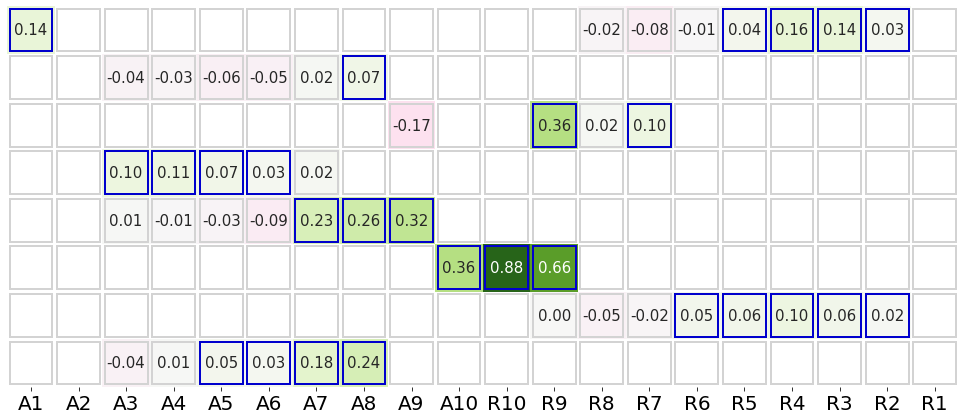

In [16]:
from scipy.stats import ttest_1samp

xticklabels = [None]*nprox*ndir
dir = 'AR'
for i in [0,1]:
    for j,prox in enumerate(prox_bins+[1]):
        xticklabels[(nprox*ndir-1)*i+((-1)**i)*j] = f"{dir[i]}{j+1}"

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(30,7), sharex=True)
clim = np.nanmax(np.abs(mean_orient_mat))
sns.heatmap(
    mean_orient_mat,
    annot=mean_orient_mat, fmt='.2f', annot_kws={'size': 15},
    cmap="PiYG",
    vmin=-clim,vmax=clim,
    ax=ax,
    cbar=False,
    square=True,
)
for i in range(len(trans_list)):
    for j in range(nprox*ndir):
        vals = all_orient_mats[:,i,j]
        vals = vals[~np.isnan(vals)]
        if pvals[i,j]<0.05/(len(trans_list)*nprox*ndir) and mean_orient_mat[i,j]>0:
            pval = wilcoxon(vals,alternative='greater').pvalue
            if pval<0.05/(len(trans_list)*nprox*ndir):
                ax.add_patch(
                    # patches.Circle((j+0.5,i+0.5),0.47,linewidth=, edgecolor='r',facecolor='none')
                    patches.Rectangle((j+0.05,i+0.05),width=0.9,height=0.9,linewidth=2,edgecolor='mediumblue',facecolor='None')
                )
            else: 
                ax.add_patch(
                # patches.Circle((j+0.5,i+0.5),0.47,linewidth=3, edgecolor='r',facecolor='none')
                patches.Rectangle((j+0.05,i+0.05),width=0.9,height=0.9,linewidth=2,edgecolor='lightgrey',facecolor='None')
                )
        elif 1:#~np.isnan(mean_orient_mat[i,j]):#pvals[i,j]<0.05/(len(trans_list)*nprox*ndir):
            ax.add_patch(
                # patches.Circle((j+0.5,i+0.5),0.47,linewidth=3, edgecolor='r',facecolor='none')
                patches.Rectangle((j+0.05,i+0.05),width=0.9,height=0.9,linewidth=2,edgecolor='lightgrey',facecolor='None')
            )

# ax.set_title(r'P(State|Stimulus)',fontsize=20) 
# state_names = ['post-shock','shock','far','retreat','???','near']
state_names = [f'State{i+1}' for i in range(K)]
# _ = ax.set_yticklabels([f'{state_names[int(s[0])]}$\longrightarrow${state_names[int(s[1])]}' for s in trans_list], fontsize=20, rotation=0)
_ = ax.set_yticks([])
_ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)
# _ = ax.set_xlabel('Stimulus category',fontsize=20)
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=15)
# cbar.ax.set_yticks(np.arange(-0.7,0.8,0.2))
# cbar.ax.set_position([0.755,0.1,1,0.775])
fig.savefig(f'figures/fig_input_influence_during_state_transitions_K{K}_D{D}_M{M}_centroid_version.eps',dpi=600,bbox_inches='tight')

(500, 8, 20) (8, 20)


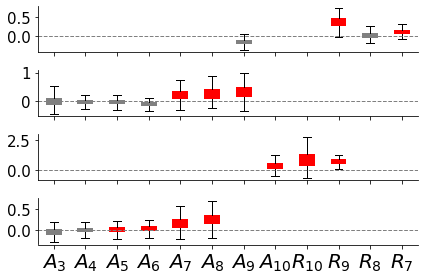

In [50]:
xticklabels = [None] * nprox * ndir
dir = "AR"
for i in [0, 1]:
    for j, prox in enumerate(prox_bins + [1]):
        xticklabels[(nprox * ndir - 1) * i + ((-1) ** i) * j] = f"${dir[i]}_"+"{"+f"{j+1}"+"}$"

all_orient_mats = np.stack(orient_mats.values(),axis=0)

print(all_orient_mats.shape, pvals.shape)
selected_trans = [2,4,5,7]
all_orient_mats1 = all_orient_mats[:,selected_trans,:]
pvals1 = pvals[selected_trans,:]
trans_list1 = [trans_list[i] for i in selected_trans]

fig,axs = plt.subplots(nrows=len(trans_list1), ncols=1, figsize=(6,4), sharex=True)
for idx_state in range(len(trans_list1)):
    contrib_values = []
    for idx_stim in range(nprox*ndir):
        if pvals1[idx_state,idx_stim]>0.05/(K*ndir*nprox):
            all_orient_mats1[:,idx_state,idx_stim] = np.nan
        tmp = all_orient_mats1[:,idx_state,idx_stim]
        contrib_values.append(tmp[~np.isnan(tmp)])

    ax = axs[idx_state]
    boxprops = dict(linestyle='-', linewidth=0, color='k')
    bplot = ax.boxplot(contrib_values, showfliers=False, patch_artist=True, boxprops=boxprops,medianprops={'linewidth':0})
    _ = ax.set_xticks(1+np.arange(nprox*ndir))
    _ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)
    ax.tick_params(axis='y',labelsize=15)
    # ax.set_ylim([0-0.01,np.max(ub_true[idx_state]+0.01)])
    ax.spines[['right','top']].set_visible(False)
    ax.axhline(0,linestyle='--',linewidth=1,color='grey')
    # ax.set_ylabel(f'{state_names[int(trans_list1[idx_state][0])]}$\longrightarrow${state_names[int(trans_list1[idx_state][1])]}', fontsize=20, rotation=0)
    ax.set_xlim([2.5,14.5])

    for idx_stim in range(nprox*ndir):
        vals = all_orient_mats1[:,idx_state,idx_stim]
        vals = vals[~np.isnan(vals)]
        pval = wilcoxon(vals,alternative='greater').pvalue
        if pval<0.05/(len(trans_list)*nprox*ndir):
            # if mean_orient_mat[idx_state,idx_stim]>0:
            # ax.get_xticklabels()[idx_stim].set_color("g")
            bplot['boxes'][idx_stim].set_facecolor("r")
            # else:
                # bplot['boxes'][idx_stim].set_facecolor("grey")
        else: 
            bplot['boxes'][idx_stim].set_facecolor("grey")
    
fig.tight_layout()
fig.savefig(f'figures/new_fig_input_influence_during_state_transitions_K{K}_D{D}_M{M}_centroid_version.jpg',dpi=600,bbox_inches='tight')

In [45]:
print(trans_list1)

['43', '21', '10', '34']
